In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import datetime
from datetime import timedelta
from time import time
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Data

In [27]:
def parser(s):
    return pd.datetime.strptime(s, '%Y-%m-%d')

production_ice_cream = pd.read_csv('O:\\ice_cream.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

production_ice_cream.rename('production', inplace=True)

production_ice_cream = production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

start_date = pd.to_datetime('2010-01-01')
production_ice_cream = production_ice_cream[start_date:]

production_ice_cream.tail(5)

DATE
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Freq: MS, Name: production, dtype: float64

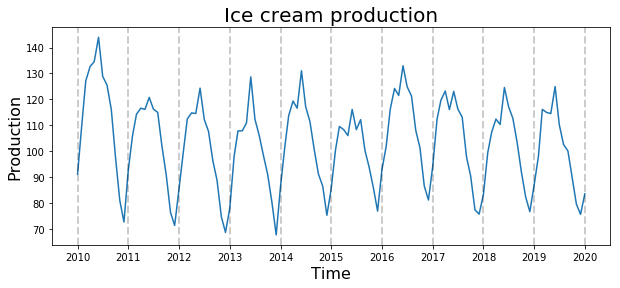

In [28]:
plt.figure(figsize=(10,4))
plt.plot(production_ice_cream)
plt.title('Ice cream production', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Production', fontsize=16)

for year in range(2010,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2, linewidth=2)

In [69]:
# Augmented Dickey-Fuller test (Stationarity)
result = adfuller(production_ice_cream)
print('ADF Statistic:', result[0])
print('p-value:', result[1]) # If p-value > 0.05, the series is non-stationary

ADF Statistic: -3.469206803861137
p-value: 0.008814055324487216


**Remark :** A seasonal component doesn't necessarly mean that the time series is not stationary.

# ACF and PACF

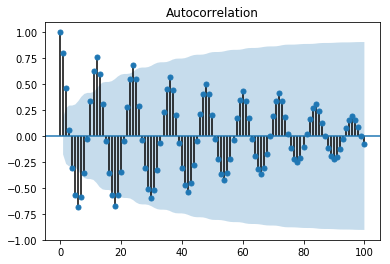

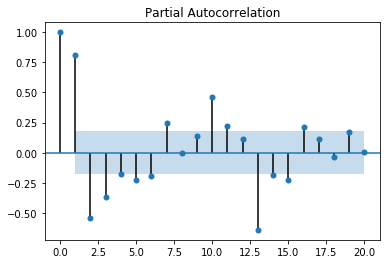

In [35]:
acf_plot = plot_acf(production_ice_cream, lags=100)
pacf_plot = plot_pacf(production_ice_cream, lags=20)

# Get training and testing sets

In [46]:
train_end = datetime(2016,12,1)
test_end = datetime(2020,1,1)

train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end + timedelta(days=1):test_end]

# Fit the AR model

In [47]:
model = ARMA(train_data, order=(3,0))

start = time()
model_fit = model.fit()
end = time()
print('Model fitting time :', end - start)

Model fitting time : 0.13417363166809082


In [48]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             production   No. Observations:                   84
Model:                     ARMA(3, 0)   Log Likelihood                -294.008
Method:                       css-mle   S.D. of innovations              7.903
Date:                Mon, 11 Nov 2024   AIC                            598.015
Time:                        13:01:03   BIC                            610.169
Sample:                    01-01-2010   HQIC                           602.901
                         - 12-01-2016                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              103.5080      2.176     47.575      0.000      99.244     107.772
ar.L1.production     1.0488      0.099     10.573      0.000       0.854       1.243
ar.L2.production    -0.0532 

# Prediction

## Regular prediction

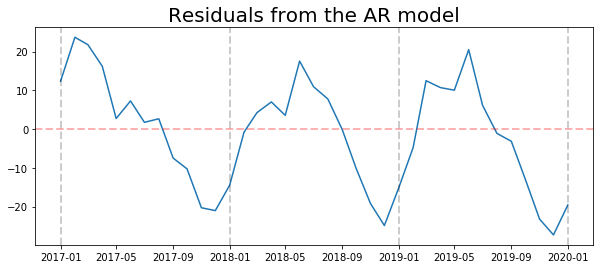

In [50]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)

residuals = test_data - predictions

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from the AR model', fontsize=20)
plt.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.3)

for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2, linewidth=2)

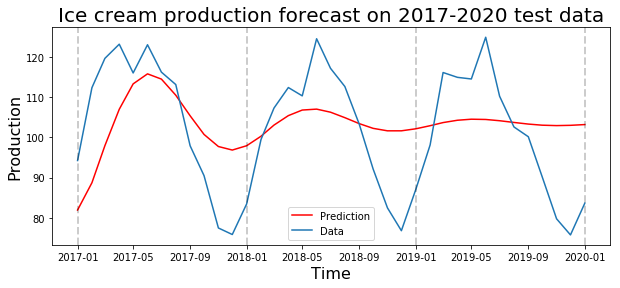

In [71]:
plt.figure(figsize=(10,4))
plt.plot(predictions, color='red', label='Prediction')
plt.plot(test_data, label='Data')
plt.title('Ice cream production forecast on 2017-2020 test data', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Production', fontsize=16)
plt.legend()

for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2, linewidth=2)

In [53]:
# Precision evaluation metrics
print('Mean Absolute Percentage Error :', np.mean(abs(residuals/test_data))) # Mean absolute percentage error
print('Root Mean Squared Error :', np.sqrt(np.mean(residuals**2)))  # Root mean squared error

Mean Absolute Percentage Error : 0.12415262468224877
Root Mean Squared Error : 14.073698065389587


# Rolling forecast origin

**Idea :** Predict one month in advance each time

In [60]:
predictions_rolling = pd.Series()

for end_date in test_data.index:
    train_data = production_ice_cream[:end_date - timedelta(days=1)]
    model = ARMA(train_data, order=(0,3))
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[end_date] = pred.loc[end_date]
    

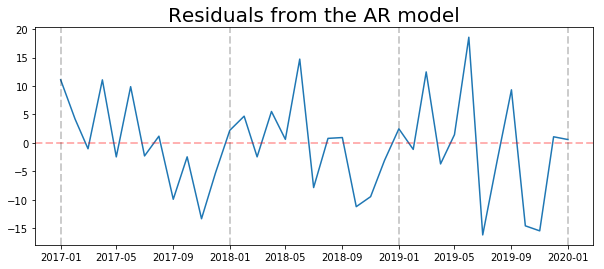

In [64]:
residuals_rolling = test_data - predictions_rolling

plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title('Residuals from the AR model', fontsize=20)
plt.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.3)

for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2, linewidth=2)

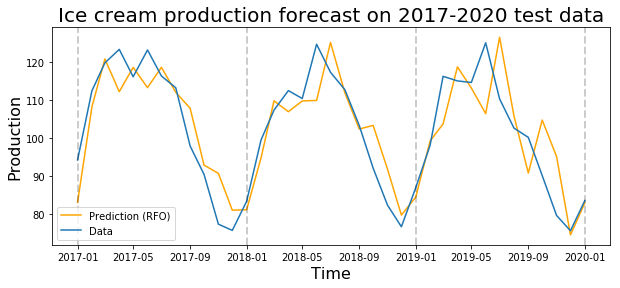

In [70]:
plt.figure(figsize=(10,4))
plt.plot(predictions_rolling, color='orange', label='Prediction (RFO)')
plt.plot(test_data, label='Data')
plt.title('Ice cream production forecast on 2017-2020 test data', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Production', fontsize=16)
plt.legend()

for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2, linewidth=2)

In [63]:
# Precision evaluation metrics
print('Mean Absolute Percentage Error :', np.mean(abs(residuals_rolling/test_data))) # Mean absolute percentage error
print('Root Mean Squared Error :', np.sqrt(np.mean(residuals_rolling**2)))           # Root mean squared error

Mean Absolute Percentage Error : 0.0640864321881923
Root Mean Squared Error : 8.356349026897304
